# Set up

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from metaformer import metaformer_baselines # load model of MetaFormer baselines
import torchvision
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import Accuracy
import torchvision.transforms as transforms

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# torch.use_deterministic_algorithms(True)

# Hyperparameters

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 10
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 512 

In [6]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 10
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 512 

# Data preparation

In [7]:
# Class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
train_transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomPerspective(distortion_scale=.3, p=.3),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

test_transform = transforms.Compose(
    [transforms.ToTensor()])

trainDS = torchvision.datasets.CIFAR10('../cifar-10/', train=True, download=True, transform=train_transform)
testDS = torchvision.datasets.CIFAR10('../cifar-10/', train=False, download=True, transform=test_transform)

print(f'[INFO] found {len(trainDS)} examples in the training set.')
print(f'[INFO] found {len(testDS)} examples in the test set.')


Files already downloaded and verified
Files already downloaded and verified
[INFO] found 50000 examples in the training set.
[INFO] found 10000 examples in the test set.


In [9]:
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainDS)

frog


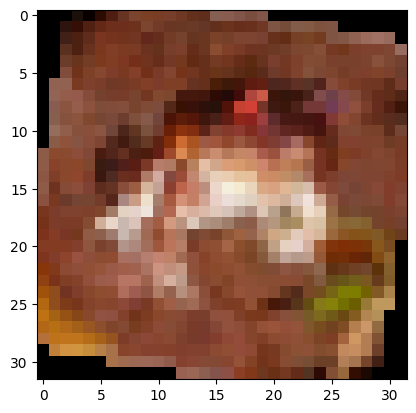

In [11]:
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print(classes[labels])

# Model

In [12]:
parameters_dict = {
    "num_classes": 10
}

In [13]:
model = metaformer_baselines.identityformer_s12(**parameters_dict) # can change different model name
model = model.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer

lossFunc = torch.nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=1e-8)
f1score = MulticlassF1Score(num_classes=10).cuda()
accuracy = Accuracy(num_classes=10,task='multiclass', average="macro").cuda()

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_F1": [], "test_F1": [],"train_acc": [], "test_acc": []}

In [14]:
bestF1 = 0
# loop over epochs
print("[INFO] Training the network.")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainF1 = 0
	totalTestF1 = 0
	totalTrainAcc = 0
	totalTestAcc = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = model(x)
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any prevF1sly accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainF1 += f1score(pred, y)
		totalTrainAcc += accuracy(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = model(x)
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestF1 += f1score(pred, y)
			totalTestAcc += accuracy(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainF1 = totalTrainF1 / trainSteps
	avgTestF1 = totalTestF1 / testSteps
	avgTrainAcc = totalTrainAcc / trainSteps
	avgTestAcc = totalTestAcc / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_F1"].append(avgTrainF1.cpu().detach().numpy())
	H["test_F1"].append(avgTestF1.cpu().detach().numpy())
	H["train_acc"].append(avgTrainAcc.cpu().detach().numpy())
	H["test_acc"].append(avgTestAcc.cpu().detach().numpy())

	# print the model training and validation information
	print(f'[INFO] EPOCH: {e + 1}/{NUM_EPOCHS}')
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train F1: {avgTrainF1:.4f}, Test F1: {avgTestF1:.4f}, Train Acc: {avgTrainAcc:.4f}, Test Acc: {avgTestAcc:.4f}")

	if avgTestF1 > bestF1:
		bestF1 = avgTestF1
		torch.save(model.state_dict(), '../models/idendtity-former.pth')
		print('Best F1 improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print(f'[INFO] total time taken to train the model: {endTime - startTime:.2f}s')
print(f'Best F1 is: {bestF1:.5f}')

[INFO] Training the network.


100%|██████████| 98/98 [00:47<00:00,  2.08it/s]


[INFO] EPOCH: 1/100
Train loss: 2.192927, Test loss: 2.1190, Train F1: 0.2123, Test F1: 0.3072, Train Acc: 0.2581, Test Acc: 0.3372
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:44<00:00,  2.20it/s]


[INFO] EPOCH: 2/100
Train loss: 2.111818, Test loss: 2.0816, Train F1: 0.3238, Test F1: 0.3565, Train Acc: 0.3436, Test Acc: 0.3723
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


[INFO] EPOCH: 3/100
Train loss: 2.080741, Test loss: 2.0584, Train F1: 0.3608, Test F1: 0.3906, Train Acc: 0.3757, Test Acc: 0.3997
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.17it/s]


[INFO] EPOCH: 4/100
Train loss: 2.061379, Test loss: 2.0485, Train F1: 0.3820, Test F1: 0.3931, Train Acc: 0.3934, Test Acc: 0.4090
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:44<00:00,  2.18it/s]


[INFO] EPOCH: 5/100
Train loss: 2.045285, Test loss: 2.0194, Train F1: 0.4004, Test F1: 0.4274, Train Acc: 0.4105, Test Acc: 0.4389
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.16it/s]


[INFO] EPOCH: 6/100
Train loss: 2.033057, Test loss: 2.0220, Train F1: 0.4142, Test F1: 0.4240, Train Acc: 0.4248, Test Acc: 0.4336


100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


[INFO] EPOCH: 7/100
Train loss: 2.017972, Test loss: 1.9940, Train F1: 0.4284, Test F1: 0.4495, Train Acc: 0.4388, Test Acc: 0.4608
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.17it/s]


[INFO] EPOCH: 8/100
Train loss: 2.008465, Test loss: 1.9886, Train F1: 0.4410, Test F1: 0.4580, Train Acc: 0.4488, Test Acc: 0.4657
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:44<00:00,  2.18it/s]


[INFO] EPOCH: 9/100
Train loss: 1.999278, Test loss: 1.9882, Train F1: 0.4494, Test F1: 0.4579, Train Acc: 0.4586, Test Acc: 0.4672


100%|██████████| 98/98 [00:45<00:00,  2.17it/s]


[INFO] EPOCH: 10/100
Train loss: 1.995528, Test loss: 1.9738, Train F1: 0.4523, Test F1: 0.4718, Train Acc: 0.4608, Test Acc: 0.4822
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.16it/s]


[INFO] EPOCH: 11/100
Train loss: 1.984301, Test loss: 1.9843, Train F1: 0.4636, Test F1: 0.4591, Train Acc: 0.4722, Test Acc: 0.4721


100%|██████████| 98/98 [00:45<00:00,  2.14it/s]


[INFO] EPOCH: 12/100
Train loss: 1.978299, Test loss: 1.9703, Train F1: 0.4703, Test F1: 0.4725, Train Acc: 0.4786, Test Acc: 0.4860
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.15it/s]


[INFO] EPOCH: 13/100
Train loss: 1.975091, Test loss: 1.9626, Train F1: 0.4748, Test F1: 0.4845, Train Acc: 0.4833, Test Acc: 0.4934
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.14it/s]


[INFO] EPOCH: 14/100
Train loss: 1.967397, Test loss: 1.9515, Train F1: 0.4826, Test F1: 0.5039, Train Acc: 0.4903, Test Acc: 0.5068
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.16it/s]


[INFO] EPOCH: 15/100
Train loss: 1.960718, Test loss: 1.9460, Train F1: 0.4913, Test F1: 0.5002, Train Acc: 0.4987, Test Acc: 0.5084


100%|██████████| 98/98 [00:45<00:00,  2.16it/s]


[INFO] EPOCH: 16/100
Train loss: 1.957934, Test loss: 1.9460, Train F1: 0.4919, Test F1: 0.5077, Train Acc: 0.4996, Test Acc: 0.5122
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.14it/s]


[INFO] EPOCH: 17/100
Train loss: 1.952111, Test loss: 1.9379, Train F1: 0.4989, Test F1: 0.5152, Train Acc: 0.5056, Test Acc: 0.5205
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.13it/s]


[INFO] EPOCH: 18/100
Train loss: 1.943009, Test loss: 1.9439, Train F1: 0.5090, Test F1: 0.5001, Train Acc: 0.5156, Test Acc: 0.5106


100%|██████████| 98/98 [00:45<00:00,  2.15it/s]


[INFO] EPOCH: 19/100
Train loss: 1.935281, Test loss: 1.9290, Train F1: 0.5164, Test F1: 0.5206, Train Acc: 0.5230, Test Acc: 0.5258
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 20/100
Train loss: 1.932025, Test loss: 1.9215, Train F1: 0.5186, Test F1: 0.5336, Train Acc: 0.5253, Test Acc: 0.5380
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.15it/s]


[INFO] EPOCH: 21/100
Train loss: 1.927274, Test loss: 1.9377, Train F1: 0.5250, Test F1: 0.5112, Train Acc: 0.5323, Test Acc: 0.5144


100%|██████████| 98/98 [00:45<00:00,  2.14it/s]


[INFO] EPOCH: 22/100
Train loss: 1.928186, Test loss: 1.9280, Train F1: 0.5236, Test F1: 0.5189, Train Acc: 0.5296, Test Acc: 0.5276


100%|██████████| 98/98 [00:45<00:00,  2.14it/s]


[INFO] EPOCH: 23/100
Train loss: 1.921697, Test loss: 1.9202, Train F1: 0.5314, Test F1: 0.5345, Train Acc: 0.5363, Test Acc: 0.5361
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 24/100
Train loss: 1.917700, Test loss: 1.9170, Train F1: 0.5334, Test F1: 0.5352, Train Acc: 0.5393, Test Acc: 0.5407
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:45<00:00,  2.13it/s]


[INFO] EPOCH: 25/100
Train loss: 1.908743, Test loss: 1.9115, Train F1: 0.5452, Test F1: 0.5413, Train Acc: 0.5506, Test Acc: 0.5461
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 26/100
Train loss: 1.906964, Test loss: 1.9050, Train F1: 0.5467, Test F1: 0.5499, Train Acc: 0.5518, Test Acc: 0.5521
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 27/100
Train loss: 1.904052, Test loss: 1.9179, Train F1: 0.5487, Test F1: 0.5311, Train Acc: 0.5538, Test Acc: 0.5399


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 28/100
Train loss: 1.898946, Test loss: 1.9088, Train F1: 0.5552, Test F1: 0.5404, Train Acc: 0.5603, Test Acc: 0.5476


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 29/100
Train loss: 1.896598, Test loss: 1.9170, Train F1: 0.5574, Test F1: 0.5296, Train Acc: 0.5626, Test Acc: 0.5393


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 30/100
Train loss: 1.891800, Test loss: 1.9036, Train F1: 0.5626, Test F1: 0.5460, Train Acc: 0.5677, Test Acc: 0.5542


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 31/100
Train loss: 1.887296, Test loss: 1.9029, Train F1: 0.5675, Test F1: 0.5483, Train Acc: 0.5728, Test Acc: 0.5549


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 32/100
Train loss: 1.884265, Test loss: 1.9021, Train F1: 0.5695, Test F1: 0.5497, Train Acc: 0.5740, Test Acc: 0.5540


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 33/100
Train loss: 1.882700, Test loss: 1.8888, Train F1: 0.5704, Test F1: 0.5640, Train Acc: 0.5755, Test Acc: 0.5679
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 34/100
Train loss: 1.876492, Test loss: 1.8925, Train F1: 0.5781, Test F1: 0.5591, Train Acc: 0.5825, Test Acc: 0.5646


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 35/100
Train loss: 1.873445, Test loss: 1.8959, Train F1: 0.5807, Test F1: 0.5558, Train Acc: 0.5855, Test Acc: 0.5604


100%|██████████| 98/98 [00:46<00:00,  2.13it/s]


[INFO] EPOCH: 36/100
Train loss: 1.870957, Test loss: 1.9018, Train F1: 0.5823, Test F1: 0.5516, Train Acc: 0.5871, Test Acc: 0.5542


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 37/100
Train loss: 1.867849, Test loss: 1.8885, Train F1: 0.5868, Test F1: 0.5635, Train Acc: 0.5915, Test Acc: 0.5681


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 38/100
Train loss: 1.864874, Test loss: 1.8928, Train F1: 0.5896, Test F1: 0.5607, Train Acc: 0.5941, Test Acc: 0.5639


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 39/100
Train loss: 1.864125, Test loss: 1.8915, Train F1: 0.5910, Test F1: 0.5584, Train Acc: 0.5950, Test Acc: 0.5636


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 40/100
Train loss: 1.862419, Test loss: 1.8789, Train F1: 0.5915, Test F1: 0.5712, Train Acc: 0.5956, Test Acc: 0.5795
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 41/100
Train loss: 1.853730, Test loss: 1.8734, Train F1: 0.6014, Test F1: 0.5773, Train Acc: 0.6067, Test Acc: 0.5853
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 42/100
Train loss: 1.854268, Test loss: 1.8829, Train F1: 0.6010, Test F1: 0.5723, Train Acc: 0.6049, Test Acc: 0.5738


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 43/100
Train loss: 1.848527, Test loss: 1.8769, Train F1: 0.6072, Test F1: 0.5793, Train Acc: 0.6113, Test Acc: 0.5820
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 44/100
Train loss: 1.849533, Test loss: 1.8775, Train F1: 0.6047, Test F1: 0.5725, Train Acc: 0.6096, Test Acc: 0.5819


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 45/100
Train loss: 1.847622, Test loss: 1.8776, Train F1: 0.6071, Test F1: 0.5692, Train Acc: 0.6120, Test Acc: 0.5787


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 46/100
Train loss: 1.842467, Test loss: 1.8714, Train F1: 0.6113, Test F1: 0.5806, Train Acc: 0.6158, Test Acc: 0.5848
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


[INFO] EPOCH: 47/100
Train loss: 1.842651, Test loss: 1.8779, Train F1: 0.6128, Test F1: 0.5736, Train Acc: 0.6167, Test Acc: 0.5788


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 48/100
Train loss: 1.837429, Test loss: 1.8620, Train F1: 0.6175, Test F1: 0.5932, Train Acc: 0.6215, Test Acc: 0.5966
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 49/100
Train loss: 1.836687, Test loss: 1.8672, Train F1: 0.6184, Test F1: 0.5860, Train Acc: 0.6225, Test Acc: 0.5887


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 50/100
Train loss: 1.834289, Test loss: 1.8600, Train F1: 0.6210, Test F1: 0.5965, Train Acc: 0.6251, Test Acc: 0.5967
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 51/100
Train loss: 1.830074, Test loss: 1.8671, Train F1: 0.6251, Test F1: 0.5864, Train Acc: 0.6287, Test Acc: 0.5910


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 52/100
Train loss: 1.826881, Test loss: 1.8634, Train F1: 0.6284, Test F1: 0.5899, Train Acc: 0.6324, Test Acc: 0.5941


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 53/100
Train loss: 1.825207, Test loss: 1.8599, Train F1: 0.6296, Test F1: 0.5905, Train Acc: 0.6335, Test Acc: 0.5960


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 54/100
Train loss: 1.822412, Test loss: 1.8577, Train F1: 0.6331, Test F1: 0.5963, Train Acc: 0.6369, Test Acc: 0.5991


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 55/100
Train loss: 1.817511, Test loss: 1.8653, Train F1: 0.6383, Test F1: 0.5898, Train Acc: 0.6414, Test Acc: 0.5923


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 56/100
Train loss: 1.815958, Test loss: 1.8611, Train F1: 0.6408, Test F1: 0.5885, Train Acc: 0.6439, Test Acc: 0.5955


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 57/100
Train loss: 1.814750, Test loss: 1.8525, Train F1: 0.6415, Test F1: 0.5999, Train Acc: 0.6449, Test Acc: 0.6041
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 58/100
Train loss: 1.809399, Test loss: 1.8488, Train F1: 0.6461, Test F1: 0.6071, Train Acc: 0.6498, Test Acc: 0.6100
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 59/100
Train loss: 1.811651, Test loss: 1.8472, Train F1: 0.6440, Test F1: 0.6032, Train Acc: 0.6472, Test Acc: 0.6097


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 60/100
Train loss: 1.808414, Test loss: 1.8575, Train F1: 0.6469, Test F1: 0.5944, Train Acc: 0.6513, Test Acc: 0.6006


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 61/100
Train loss: 1.804047, Test loss: 1.8439, Train F1: 0.6518, Test F1: 0.6148, Train Acc: 0.6550, Test Acc: 0.6153
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 62/100
Train loss: 1.802854, Test loss: 1.8430, Train F1: 0.6536, Test F1: 0.6115, Train Acc: 0.6570, Test Acc: 0.6145


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 63/100
Train loss: 1.801589, Test loss: 1.8606, Train F1: 0.6542, Test F1: 0.5923, Train Acc: 0.6583, Test Acc: 0.5974


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 64/100
Train loss: 1.798390, Test loss: 1.8434, Train F1: 0.6578, Test F1: 0.6093, Train Acc: 0.6612, Test Acc: 0.6127


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 65/100
Train loss: 1.796743, Test loss: 1.8470, Train F1: 0.6592, Test F1: 0.6097, Train Acc: 0.6627, Test Acc: 0.6110


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 66/100
Train loss: 1.795002, Test loss: 1.8473, Train F1: 0.6614, Test F1: 0.6060, Train Acc: 0.6643, Test Acc: 0.6098


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 67/100
Train loss: 1.790939, Test loss: 1.8420, Train F1: 0.6659, Test F1: 0.6110, Train Acc: 0.6691, Test Acc: 0.6135


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 68/100
Train loss: 1.792457, Test loss: 1.8343, Train F1: 0.6635, Test F1: 0.6175, Train Acc: 0.6670, Test Acc: 0.6222
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 69/100
Train loss: 1.788395, Test loss: 1.8398, Train F1: 0.6666, Test F1: 0.6110, Train Acc: 0.6704, Test Acc: 0.6156


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 70/100
Train loss: 1.782433, Test loss: 1.8337, Train F1: 0.6746, Test F1: 0.6215, Train Acc: 0.6778, Test Acc: 0.6250
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 71/100
Train loss: 1.781040, Test loss: 1.8396, Train F1: 0.6760, Test F1: 0.6152, Train Acc: 0.6794, Test Acc: 0.6184


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 72/100
Train loss: 1.783460, Test loss: 1.8295, Train F1: 0.6734, Test F1: 0.6227, Train Acc: 0.6767, Test Acc: 0.6270
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 73/100
Train loss: 1.781515, Test loss: 1.8468, Train F1: 0.6746, Test F1: 0.6067, Train Acc: 0.6782, Test Acc: 0.6104


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 74/100
Train loss: 1.777762, Test loss: 1.8327, Train F1: 0.6788, Test F1: 0.6196, Train Acc: 0.6822, Test Acc: 0.6243


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 75/100
Train loss: 1.774101, Test loss: 1.8425, Train F1: 0.6831, Test F1: 0.6140, Train Acc: 0.6862, Test Acc: 0.6137


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 76/100
Train loss: 1.773699, Test loss: 1.8326, Train F1: 0.6834, Test F1: 0.6224, Train Acc: 0.6864, Test Acc: 0.6266


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 77/100
Train loss: 1.772092, Test loss: 1.8344, Train F1: 0.6850, Test F1: 0.6203, Train Acc: 0.6879, Test Acc: 0.6229


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 78/100
Train loss: 1.770648, Test loss: 1.8318, Train F1: 0.6856, Test F1: 0.6203, Train Acc: 0.6891, Test Acc: 0.6254


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 79/100
Train loss: 1.768928, Test loss: 1.8368, Train F1: 0.6879, Test F1: 0.6187, Train Acc: 0.6910, Test Acc: 0.6214


100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


[INFO] EPOCH: 80/100
Train loss: 1.767413, Test loss: 1.8272, Train F1: 0.6895, Test F1: 0.6260, Train Acc: 0.6927, Test Acc: 0.6305
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


[INFO] EPOCH: 81/100
Train loss: 1.766302, Test loss: 1.8366, Train F1: 0.6908, Test F1: 0.6129, Train Acc: 0.6941, Test Acc: 0.6199


100%|██████████| 98/98 [00:46<00:00,  2.09it/s]


[INFO] EPOCH: 82/100
Train loss: 1.761794, Test loss: 1.8247, Train F1: 0.6953, Test F1: 0.6316, Train Acc: 0.6982, Test Acc: 0.6333
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:47<00:00,  2.08it/s]


[INFO] EPOCH: 83/100
Train loss: 1.760341, Test loss: 1.8186, Train F1: 0.6972, Test F1: 0.6381, Train Acc: 0.6997, Test Acc: 0.6395
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


[INFO] EPOCH: 84/100
Train loss: 1.756403, Test loss: 1.8330, Train F1: 0.7009, Test F1: 0.6218, Train Acc: 0.7033, Test Acc: 0.6249


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 85/100
Train loss: 1.756282, Test loss: 1.8251, Train F1: 0.7004, Test F1: 0.6308, Train Acc: 0.7036, Test Acc: 0.6321


100%|██████████| 98/98 [00:46<00:00,  2.10it/s]


[INFO] EPOCH: 86/100
Train loss: 1.754809, Test loss: 1.8187, Train F1: 0.7028, Test F1: 0.6370, Train Acc: 0.7063, Test Acc: 0.6381


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 87/100
Train loss: 1.752320, Test loss: 1.8282, Train F1: 0.7050, Test F1: 0.6286, Train Acc: 0.7075, Test Acc: 0.6297


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 88/100
Train loss: 1.753415, Test loss: 1.8283, Train F1: 0.7032, Test F1: 0.6301, Train Acc: 0.7059, Test Acc: 0.6297


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 89/100
Train loss: 1.749323, Test loss: 1.8220, Train F1: 0.7088, Test F1: 0.6325, Train Acc: 0.7109, Test Acc: 0.6341


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 90/100
Train loss: 1.750590, Test loss: 1.8181, Train F1: 0.7067, Test F1: 0.6330, Train Acc: 0.7095, Test Acc: 0.6392


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 91/100
Train loss: 1.743972, Test loss: 1.8132, Train F1: 0.7136, Test F1: 0.6441, Train Acc: 0.7169, Test Acc: 0.6462
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 92/100
Train loss: 1.744032, Test loss: 1.8115, Train F1: 0.7129, Test F1: 0.6395, Train Acc: 0.7157, Test Acc: 0.6465


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 93/100
Train loss: 1.742991, Test loss: 1.8106, Train F1: 0.7145, Test F1: 0.6439, Train Acc: 0.7176, Test Acc: 0.6471


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 94/100
Train loss: 1.738208, Test loss: 1.8112, Train F1: 0.7185, Test F1: 0.6414, Train Acc: 0.7209, Test Acc: 0.6453


100%|██████████| 98/98 [00:46<00:00,  2.12it/s]


[INFO] EPOCH: 95/100
Train loss: 1.734787, Test loss: 1.8113, Train F1: 0.7233, Test F1: 0.6429, Train Acc: 0.7258, Test Acc: 0.6444


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 96/100
Train loss: 1.738090, Test loss: 1.8051, Train F1: 0.7192, Test F1: 0.6483, Train Acc: 0.7221, Test Acc: 0.6523
Best F1 improved. Model saved.


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 97/100
Train loss: 1.736027, Test loss: 1.8110, Train F1: 0.7218, Test F1: 0.6455, Train Acc: 0.7246, Test Acc: 0.6481


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 98/100
Train loss: 1.731834, Test loss: 1.8112, Train F1: 0.7266, Test F1: 0.6431, Train Acc: 0.7288, Test Acc: 0.6464


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 99/100
Train loss: 1.731710, Test loss: 1.8102, Train F1: 0.7263, Test F1: 0.6464, Train Acc: 0.7286, Test Acc: 0.6484


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


[INFO] EPOCH: 100/100
Train loss: 1.727540, Test loss: 1.8070, Train F1: 0.7310, Test F1: 0.6468, Train Acc: 0.7334, Test Acc: 0.6502
[INFO] total time taken to train the model: 4780.13s
Best F1 is: 0.64825


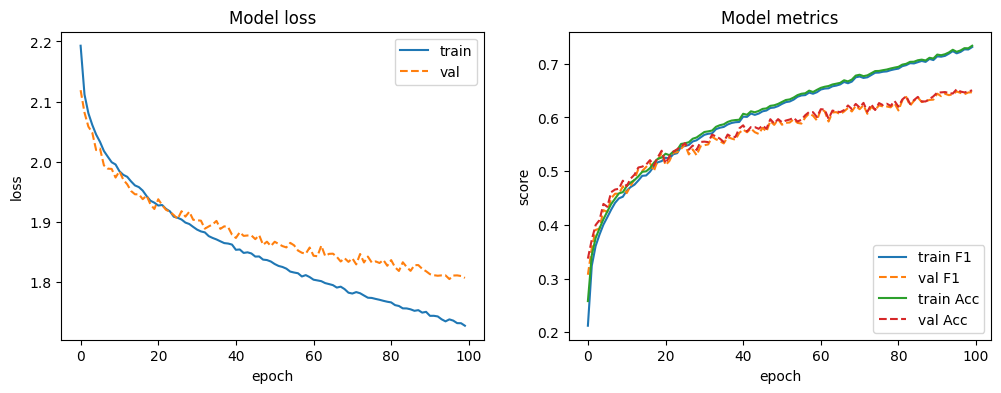

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_F1'])
plt.plot(H['test_F1'], linestyle='dotted')
plt.plot(H['train_acc'])
plt.plot(H['test_acc'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train F1', 'val F1', 'train Acc', 'val Acc'], loc='lower right')

plt.show()